# Project overview and results

### Overview

This model automates a manual inspection process in a semiconductor environment. Wafers undergo various conditions across hundreds of fabrication steps. This script focuses on detecting and flagging defects on the backside of wafers, which is less rigorously monitored compared to the frontside.

Images are collected from an automated, high-speed image capture system. For training and testing, images are manually labeled as "PASS" or "FAIL." Due to the rarity of defects, the Augmentor library was used to increase the number of "FAIL" images from 18 to 250. The CV2 library was used to focus on the central circular region of the wafers, where defects are typically found, excluding the outer regions that do not provide valuable diagnostic information.

### Methods

Various models were tested, including SVC, logistic regression, random forest, and ensemble methods with SVC, gradient boost, and voting classifiers.

### Results

All models achieved high accuracy, F1 scores, and recall (>98%). Although this suggests potential overfitting, the significant contrast between "PASS" and "FAIL" images supports the results. The average, normalized distributions of pixel values for each class were plotted. The pixel value bins represent the intensity distribution of the grayscale images, with 0.7 indicating higher intensity (lighter pixels) and 0.1 indicating darker pixels. The difference between "PASS" and "FAIL" histograms showed that "FAIL" images have more darker pixels.

### Business Impact

The model has been applied to a directory containing thousands of raw images, succesfully detecting 82 images with defects. This model will be implemented to scan images as they are collected, and will benefit the business in the following ways:

1) Identifying wafer defects without manual review.
2) Aiding in rapid root cause analysis and near real-time process monitoring.
3) Saving hundreds of engineering hours annually.
4) Increasing yields.

# Image classification system for backside wafer defects

In [3]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import Augmentor

from skimage.io import imread
from skimage.transform import resize
from sklearn import svm
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from concurrent.futures import ThreadPoolExecutor


# Generate more samples, pre-process images and display histograms


### Generate more samples if needed

#### Select the inner radius of the wafer

In [ ]:
# import cv2
# import numpy as np
# import os

# # Directories containing the images
# directories = [
#     r"C:\Users\scallred\ImageClassifierCapstone\FAIL\modified",
#     r"C:\Users\scallred\ImageClassifierCapstone\PASS\modified"
# ]

# # Function to process images
# def process_image(image_path, output_dir):
#     # Load the image
#     image = cv2.imread(image_path)

#     # Create a mask with the same dimensions as the image, initialized to black
#     mask = np.zeros(image.shape[:2], dtype=np.uint8)

#     # Define the center and radius of the circle
#     center = (image.shape[1] // 2, image.shape[0] // 2)  # Center of the image
#     radius = min(center) // 2  # Adjust the radius as needed

#     # Draw a white filled circle on the mask
#     cv2.circle(mask, center, radius, (255), thickness=-1)

#     # Use the mask to keep only the inner circle
#     masked_image = cv2.bitwise_and(image, image, mask=mask)

#     # Save the images in the modified subfolder
#     base_filename = os.path.basename(image_path)
#     name, ext = os.path.splitext(base_filename)
#     modified_dir = os.path.join(output_dir, "modified")
#     os.makedirs(modified_dir, exist_ok=True)
#     # cv2.imwrite(os.path.join(modified_dir, f"{name}_original{ext}"), image)
#     cv2.imwrite(os.path.join(modified_dir, f"{name}_masked{ext}"), masked_image)

# # Process all images in the directories
# for directory in directories:
#     for filename in os.listdir(directory):
#         if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
#             image_path = os.path.join(directory, filename)
#             process_image(image_path, directory)


#### Generate more images using aumentor

In [4]:
# import os
# import numpy as np
# import matplotlib.pyplot as plt
# from skimage.io import imread
# from skimage.transform import resize
# from concurrent.futures import ThreadPoolExecutor
# import Augmentor

# categories = ['PASS', 'FAIL']
# datadir = "C:\\Users\\scallred\\ImageClassifierCapstone\\"

# def augment_images(category):
#     p = Augmentor.Pipeline(source_directory=os.path.join(datadir, category, "modified"), output_directory=os.path.join(datadir, f"augmented_{category}"))
    
#     # Add more random transformations
#     p.random_distortion(probability=0.8, grid_width=20, grid_height=20, magnitude=1)
#     p.flip_left_right(probability=0.5)
#     p.flip_top_bottom(probability=0.5)
#     p.flip_random(probability=0.5)
   
#     # Ensure aspect ratio is maintained
#     p.resize(probability=1.0, width=1000, height=1000, resample_filter="BICUBIC")
    
#     p.sample(250)

# def process_image(category, img):
#     img_array = imread(os.path.join(datadir, f"augmented_{category}", img))
#     img_resized = resize(img_array, (1000, 1000, 3))  # resize image
#     return img_resized.flatten(), categories.index(category)

# # Augment images
# for category in categories:
#     augment_images(category)




Initialised with 79 image(s) found.
Output directory set to C:\Users\scallred\ImageClassifierCapstone\augmented_PASS.

Processing <PIL.Image.Image image mode=RGB size=1000x1000 at 0x256CCF469D0>: 100%|██████████| 250/250 [00:29<00:00,  8.45 Samples/s]


Initialised with 18 image(s) found.
Output directory set to C:\Users\scallred\ImageClassifierCapstone\augmented_FAIL.

Processing <PIL.Image.Image image mode=RGB size=1000x1000 at 0x2569C39E950>: 100%|██████████| 250/250 [00:30<00:00,  8.15 Samples/s]


### Process images and plot individual histograms

In [43]:
# Process augmented images and plot individual histograms
categories = ['PASS', 'FAIL']
datadir = r"C:\Users\scallred\MIDS_SVC_MODEL"

def process_image(category, img):
    img_array = imread(os.path.join(datadir, f"{category}", img))
    img_resized = resize(img_array, (1000, 1000, 3))  # resize image
    return img_resized.flatten(), categories.index(category)

with ThreadPoolExecutor() as executor:
    futures = []
    for category in categories:
        path = os.path.join(datadir, f"{category}")
        for img in os.listdir(path):
            futures.append(executor.submit(process_image, category, img))
    
    for future in futures:
        flat_data, target = future.result()
        
        # # Plot histogram for each image
        # plt.figure()
        # plt.hist(flat_data, bins=50, color='b', alpha=0.7)
        # plt.title(f'Histogram for {categories[target]} Category - Image')
        # plt.xlabel('Pixel Values')
        # plt.ylabel('Frequency')
        # plt.show()

### Process images and plot difference histogram

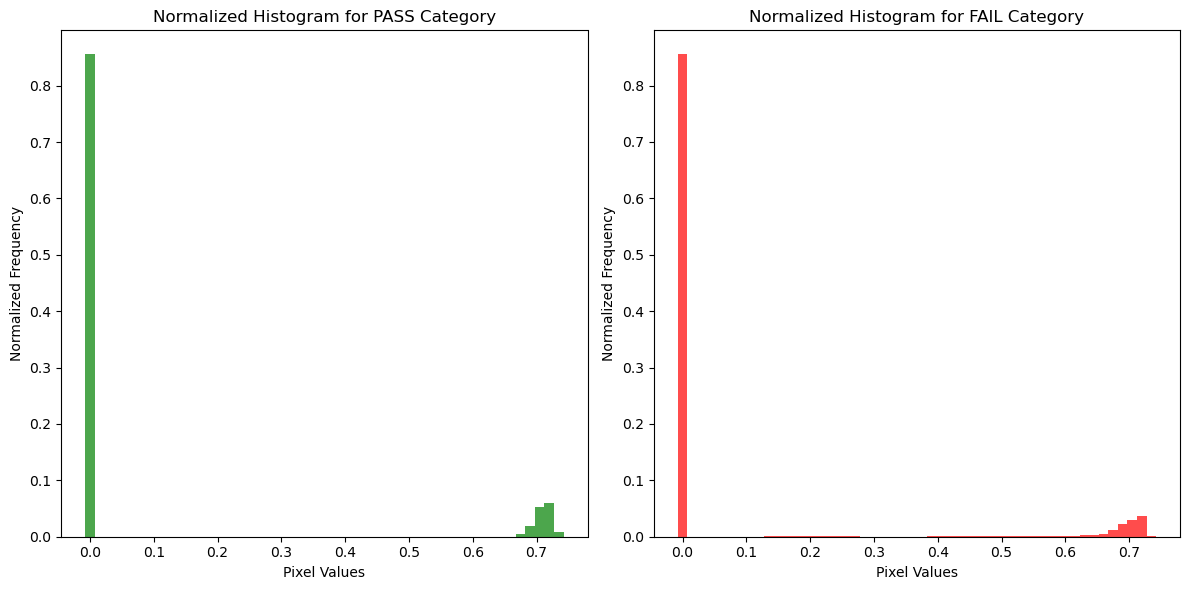

Differences between PASS and FAIL histograms (normalized frequencies):
[ 4.3700000e-05  5.2000000e-08  3.2000000e-08 -6.4000000e-08
 -8.6400000e-07  3.6400000e-07 -1.6000000e-07  1.2400000e-07
 -8.8480000e-05 -9.4620400e-04 -1.1485880e-03 -9.3899600e-04
 -6.8010000e-04 -5.3359600e-04 -4.9094800e-04 -5.2842400e-04
 -4.5688800e-04 -4.0918800e-04 -3.6658000e-04 -3.3406000e-04
 -3.2104400e-04 -3.0861600e-04 -3.0990400e-04 -3.1542000e-04
 -3.1946000e-04 -3.4574800e-04 -4.4177600e-04 -6.0933200e-04
 -1.1353280e-03 -1.6517680e-03 -2.0140400e-03 -1.8732440e-03
 -1.4835160e-03 -1.2650480e-03 -1.1718160e-03 -1.1324200e-03
 -1.1314120e-03 -1.1725200e-03 -1.2202600e-03 -1.3540920e-03
 -1.5443360e-03 -1.7766320e-03 -2.1315360e-03 -2.6657920e-03
 -4.8052680e-03 -8.2901080e-03 -3.7431600e-03  2.3176412e-02
  2.2210368e-02  6.0256840e-03]


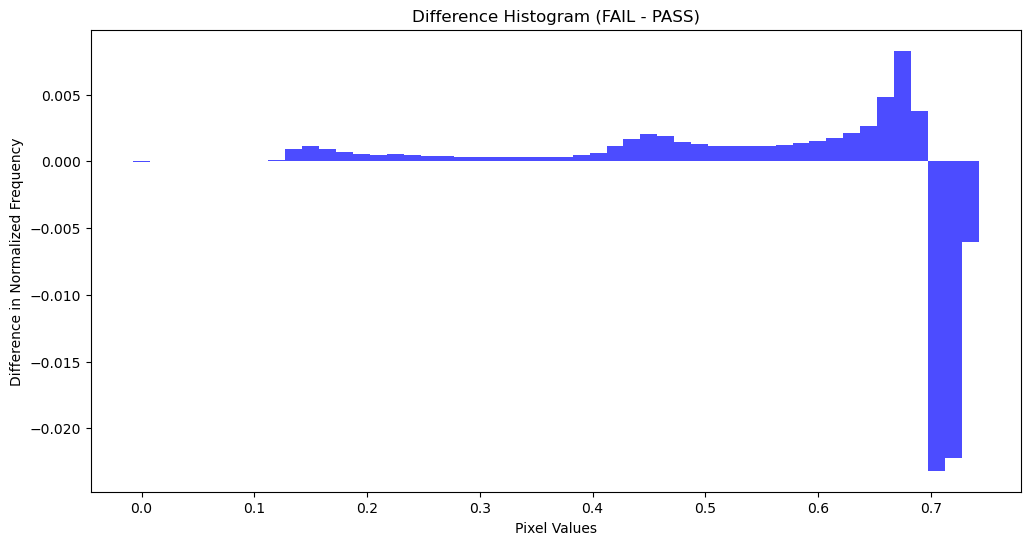

Differences between FAIL and PASS histograms (normalized frequencies):
[-4.3700000e-05 -5.2000000e-08 -3.2000000e-08  6.4000000e-08
  8.6400000e-07 -3.6400000e-07  1.6000000e-07 -1.2400000e-07
  8.8480000e-05  9.4620400e-04  1.1485880e-03  9.3899600e-04
  6.8010000e-04  5.3359600e-04  4.9094800e-04  5.2842400e-04
  4.5688800e-04  4.0918800e-04  3.6658000e-04  3.3406000e-04
  3.2104400e-04  3.0861600e-04  3.0990400e-04  3.1542000e-04
  3.1946000e-04  3.4574800e-04  4.4177600e-04  6.0933200e-04
  1.1353280e-03  1.6517680e-03  2.0140400e-03  1.8732440e-03
  1.4835160e-03  1.2650480e-03  1.1718160e-03  1.1324200e-03
  1.1314120e-03  1.1725200e-03  1.2202600e-03  1.3540920e-03
  1.5443360e-03  1.7766320e-03  2.1315360e-03  2.6657920e-03
  4.8052680e-03  8.2901080e-03  3.7431600e-03 -2.3176412e-02
 -2.2210368e-02 -6.0256840e-03]


In [20]:
import os
import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.transform import resize
from concurrent.futures import ThreadPoolExecutor
import cv2

categories = ['PASS', 'FAIL']
flat_data_arr = []  # input array
target_arr = []  # output array
datadir = r"C:\Users\scallred\MIDS_SVC_MODEL"

def process_image(category, img):
    img_path = os.path.join(datadir, category, img)
    if not os.path.isfile(img_path):
        raise FileNotFoundError(f"The file {img_path} does not exist.")
    try:
        img_array = imread(img_path, plugin='pil')  # Specify the plugin if needed
        img_resized = resize(img_array, (1000, 1000, 3))  # Resize image
        return img_resized.flatten(), categories.index(category)
    except PermissionError:
        raise PermissionError(f"Permission denied: '{img_path}'. Ensure the folder is either 'PASS' or 'FAIL' and you have the correct permissions.")

with ThreadPoolExecutor() as executor:
    futures = []
    for category in categories:
        path = os.path.join(datadir, category)
        for img in os.listdir(path):
            futures.append(executor.submit(process_image, category, img))
    
    for future in futures:
        flat_data, target = future.result()
        flat_data_arr.append(flat_data)
        target_arr.append(target)

flat_data = np.array(flat_data_arr)
targets = np.array(target_arr)

# Create histograms for 'PASS' and 'FAIL' categories
pass_indices = np.where(targets == categories.index('PASS'))
fail_indices = np.where(targets == categories.index('FAIL'))

plt.figure(figsize=(12, 6))

# Determine the common range for x-axis (pixel values)
all_pixel_values = flat_data.flatten()
min_pixel_value = np.min(all_pixel_values)
max_pixel_value = np.max(all_pixel_values)

# Calculate the normalized sum for each category
pass_hist, pass_bins = np.histogram(flat_data[pass_indices].flatten(), bins=50, range=(min_pixel_value, max_pixel_value))
fail_hist, fail_bins = np.histogram(flat_data[fail_indices].flatten(), bins=50, range=(min_pixel_value, max_pixel_value))

pass_hist_normalized = pass_hist / np.sum(pass_hist)
fail_hist_normalized = fail_hist / np.sum(fail_hist)

plt.subplot(1, 2, 1)
plt.bar(pass_bins[:-1], pass_hist_normalized, width=np.diff(pass_bins), color='g', alpha=0.7)
plt.title('Normalized Histogram for PASS Category')
plt.xlabel('Pixel Values')
plt.ylabel('Normalized Frequency')

plt.subplot(1, 2, 2)
plt.bar(fail_bins[:-1], fail_hist_normalized, width=np.diff(fail_bins), color='r', alpha=0.7)
plt.title('Normalized Histogram for FAIL Category')
plt.xlabel('Pixel Values')
plt.ylabel('Normalized Frequency')

plt.tight_layout()
plt.show()

# Compare the two histograms to determine the differences
difference = pass_hist_normalized - fail_hist_normalized

print("Differences between PASS and FAIL histograms (normalized frequencies):")
print(difference)

# Create histograms for 'PASS' and 'FAIL' categories
pass_indices = np.where(targets == categories.index('PASS'))
fail_indices = np.where(targets == categories.index('FAIL'))

# Determine the common range for x-axis (pixel values)
all_pixel_values = flat_data.flatten()
min_pixel_value = np.min(all_pixel_values)
max_pixel_value = np.max(all_pixel_values)

# Calculate the normalized sum for each category
pass_hist, pass_bins = np.histogram(flat_data[pass_indices].flatten(), bins=50, range=(min_pixel_value, max_pixel_value))
fail_hist, fail_bins = np.histogram(flat_data[fail_indices].flatten(), bins=50, range=(min_pixel_value, max_pixel_value))

pass_hist_normalized = pass_hist / np.sum(pass_hist)
fail_hist_normalized = fail_hist / np.sum(fail_hist)

# Subtract the PASS histogram from the FAIL histogram
difference_histogram = fail_hist_normalized - pass_hist_normalized

# Plot the difference histogram
plt.figure(figsize=(12, 6))
plt.bar(pass_bins[:-1], difference_histogram, width=np.diff(pass_bins), color='b', alpha=0.7)
plt.title('Difference Histogram (FAIL - PASS)')
plt.xlabel('Pixel Values')
plt.ylabel('Difference in Normalized Frequency')
plt.show()

print("Differences between FAIL and PASS histograms (normalized frequencies):")
print(difference_histogram)


# View the images

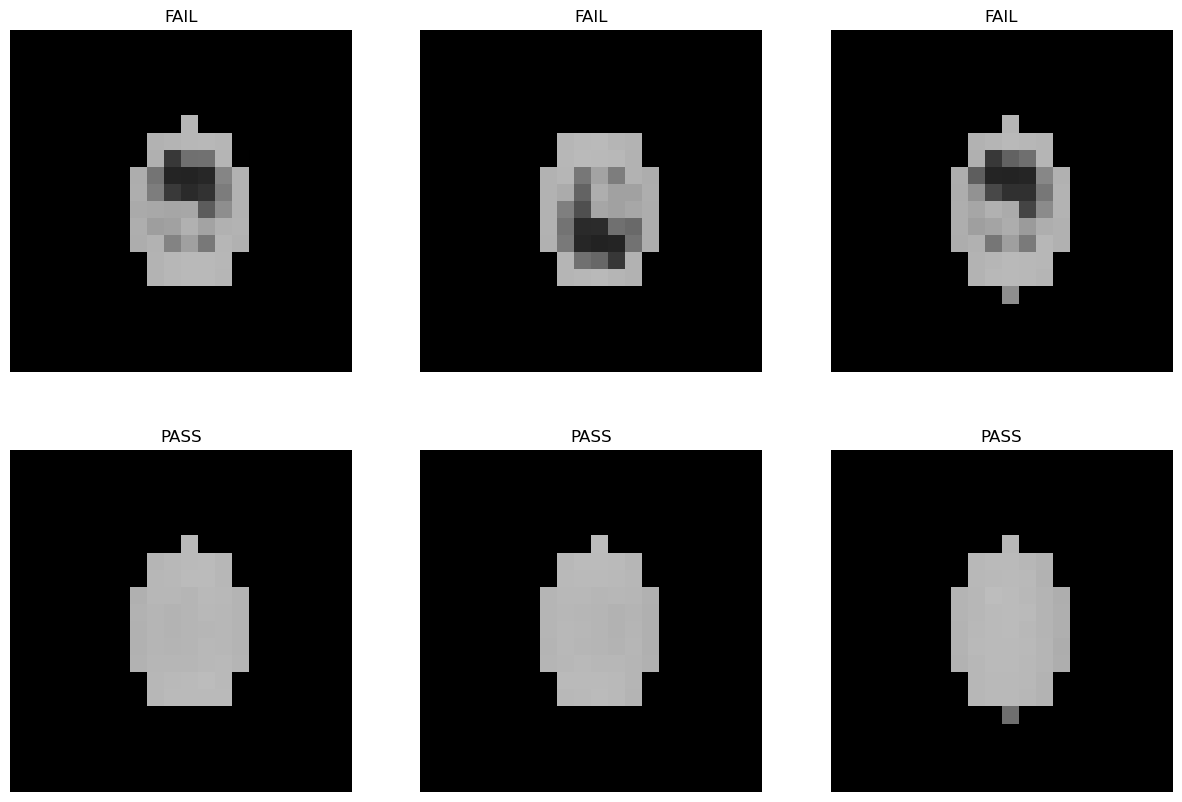

In [42]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming flat_data, categories, and targets are already defined
# Filter the indices of images that belong to the 'FAIL' and 'PASS' categories
fail_indices = [i for i, target in enumerate(targets) if categories[target] == 'FAIL']
pass_indices = [i for i, target in enumerate(targets) if categories[target] == 'PASS']

# Select 3 images from each category
selected_fail_indices = fail_indices[:3]
selected_pass_indices = pass_indices[:3]

# Function to downsample and convert image data to float values
def process_image_data(indices):
    processed_images = []
    for idx in indices:
        image_data = flat_data[idx].reshape(1000, 1000, 3)
        resized_image_data = image_data[::50, ::50]  # Downsample to 20x20
        processed_images.append(resized_image_data.astype(float))
    return processed_images

# Process images
fail_images = process_image_data(selected_fail_indices)
pass_images = process_image_data(selected_pass_indices)

# Plot the images
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

for i, (fail_img, pass_img) in enumerate(zip(fail_images, pass_images)):
    axes[0, i].imshow(fail_img)
    axes[0, i].set_title("FAIL")
    axes[0, i].axis('off')
    
    axes[1, i].imshow(pass_img)
    axes[1, i].set_title("PASS")
    axes[1, i].axis('off')

plt.show()


# Split for training

In [29]:
x_train, x_test, y_train, y_test = train_test_split(flat_data, targets, test_size=0.3)

In [30]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((350, 3000000), (350,), (150, 3000000), (150,))

# Grid search for kernel of svc

In [ ]:
# # Standardize the features
# scaler = StandardScaler()
# X_train = scaler.fit_transform(x_train)
# X_test = scaler.transform(x_test)

# # Create a SVC classifier
# svc = SVC()

# # Define the grid of hyperparameters 'params'
# params = {
#     'kernel': ['linear', 'poly', 'rbf', 'sigmoid']
# }

# # Perform grid search
# grid_search = GridSearchCV(estimator=svc, param_grid=params, cv=5)
# grid_search.fit(X_train, y_train)

# # Get the optimal hyperparameters from the grid search
# best_params = grid_search.best_params_

# # Train the classifier with the optimal hyperparameters
# svc = SVC(kernel=best_params['kernel'])
# svc.fit(X_train, y_train)

# #average fit time
# cv_results = cross_validate(svc, X_train, y_train, cv=5, return_train_score=False)
# avg_fit_time = np.mean(cv_results['fit_time'])
# print(f'Average fit time for SVC: {avg_fit_time} seconds')

# # Make predictions on the train and test sets
# y_train_pred = svc.predict(X_train)
# y_test_pred = svc.predict(X_test)

# # Calculate the train and test scores
# train_score = accuracy_score(y_train, y_train_pred)
# test_score = accuracy_score(y_test, y_test_pred)

# # Print the train score, test score, and optimal hyperparameters
# print(f"Train score: {train_score}")
# print(f"Test score: {test_score}")
# print(f"Optimal hyperparameters: {best_params}")

In [ ]:
# Grid Search Results

# Average fit time for SVC: 2.2186885356903074 seconds
# Train score: 1.0
# Test score: 1.0
# Optimal hyperparameters: {'kernel': 'linear'}

# Grid search for C value

In [ ]:
# # Standardize the features
# scaler = StandardScaler()
# X_train = scaler.fit_transform(x_train)
# X_test = scaler.transform(x_test)

# # Create a SVC classifier
# svc = SVC(kernel='linear')

# # Define the grid of hyperparameters 'params'
# params = {
#     'C': [0.1, 1, 10, 100, 1000]
# }

# # Perform grid search
# grid_search = GridSearchCV(estimator=svc, param_grid=params, cv=5)
# grid_search.fit(X_train, y_train)

# # Get the optimal hyperparameters from the grid search
# best_params = grid_search.best_params_

# # Train the classifier with the optimal hyperparameters
# svc = SVC(kernel='linear', C=best_params['C'])
# svc.fit(X_train, y_train)

# # Average fit time
# cv_results = cross_validate(svc, X_train, y_train, cv=5, return_train_score=False)
# avg_fit_time = np.mean(cv_results['fit_time'])
# print(f'Average fit time for SVC: {avg_fit_time} seconds')

# # Make predictions on the train and test sets
# y_train_pred = svc.predict(X_train)
# y_test_pred = svc.predict(X_test)

# # Calculate the train and test scores
# train_score = accuracy_score(y_train, y_train_pred)
# test_score = accuracy_score(y_test, y_test_pred)

# # Print the train score, test score, and optimal hyperparameters
# print(f"Train score: {train_score}")
# print(f"Test score: {test_score}")
# print(f"Optimal hyperparameters: {best_params}")


In [ ]:
# Average fit time for SVC: 2.341265058517456 seconds
# Train score: 1.0
# Test score: 1.0
# Optimal hyperparameters: {'C': 0.1}

# Grid search Logistics Regression

In [53]:
# # Splitting the data
# x_train, x_test, y_train, y_test = train_test_split(flat_data, targets, test_size=0.5)

# # Defining the parameter grid
# param_grid = {
#     'C': [0.1, 1, 10, 100],
#     'solver': ['newton-cg', 'lbfgs', 'liblinear']
# }

# # Initializing the logistic regression model
# log_reg = LogisticRegression(max_iter=10000)

# # Setting up the grid search
# grid_search = GridSearchCV(estimator=log_reg, param_grid=param_grid, cv=5, scoring='accuracy')

# # Fitting the grid search
# grid_search.fit(x_train, y_train)

# # Best parameters and best score
# best_params = grid_search.best_params_
# best_score = grid_search.best_score_

# print("Best Parameters:", best_params)
# print("Best Score:", best_score)


# Train Logistic Regression


In [52]:
# Splitting the data
# x_train, x_test, y_train, y_test = train_test_split(flat_data, targets, test_size=0.3)

# Initializing and training the logistic regression model
log_reg = LogisticRegression(max_iter=10000, C=1,solver='lbfgs')
log_reg.fit(x_train, y_train)


LogisticRegression(C=1, max_iter=10000)

In [54]:
y_pred = log_reg.predict(x_test)
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(f"Classification Report:\n {classification_report(y_test, y_pred)}")

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Generate and print the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print(f"Confusion Matrix:\n{conf_matrix}")

Accuracy: 0.98
Classification Report:
               precision    recall  f1-score   support

           0       0.96      1.00      0.98        69
           1       1.00      0.96      0.98        81

    accuracy                           0.98       150
   macro avg       0.98      0.98      0.98       150
weighted avg       0.98      0.98      0.98       150

Confusion Matrix:
[[69  0]
 [ 3 78]]


# Train SVC

In [56]:
# x_train, x_test, y_train, y_test = train_test_split(flat_data, targets, test_size=0.5)

svc = svm.SVC(kernel='linear', C=0.1)
svc.fit(x_train, y_train)


SVC(C=0.1, kernel='linear')

In [58]:
y_pred = svc.predict(x_test)
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(f"Classification Report:\n {classification_report(y_test, y_pred)}")

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Generate and print the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print(f"Confusion Matrix:\n{conf_matrix}")


Accuracy: 0.9933333333333333
Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      0.99        69
           1       1.00      0.99      0.99        81

    accuracy                           0.99       150
   macro avg       0.99      0.99      0.99       150
weighted avg       0.99      0.99      0.99       150

Confusion Matrix:
[[69  0]
 [ 1 80]]


# Train Random Forest Classifier

Accuracy: 1.0
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        68
           1       1.00      1.00      1.00        82

    accuracy                           1.00       150
   macro avg       1.00      1.00      1.00       150
weighted avg       1.00      1.00      1.00       150

Confusion Matrix:
[[68  0]
 [ 0 82]]


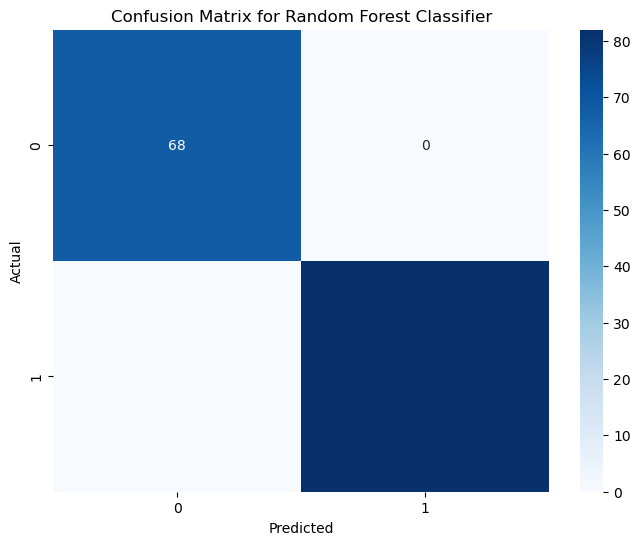

In [62]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming flat_data and targets are already defined
x_train, x_test, y_train, y_test = train_test_split(flat_data, targets, test_size=0.3)

# Initialize the Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100)

# Fit the model
rf_classifier.fit(x_train, y_train)

# Make predictions
y_pred = rf_classifier.predict(x_test)

# Evaluate accuracy
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(f"Classification Report:\n{classification_report(y_test, y_pred)}")

# Generate and print the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print(f"Confusion Matrix:\n{conf_matrix}")

# Visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Random Forest Classifier')
plt.show()


# Train Ensemble Methods

--- Random Forest ---
Accuracy: 1.0
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        79
           1       1.00      1.00      1.00        71

    accuracy                           1.00       150
   macro avg       1.00      1.00      1.00       150
weighted avg       1.00      1.00      1.00       150

Confusion Matrix:
[[79  0]
 [ 0 71]]


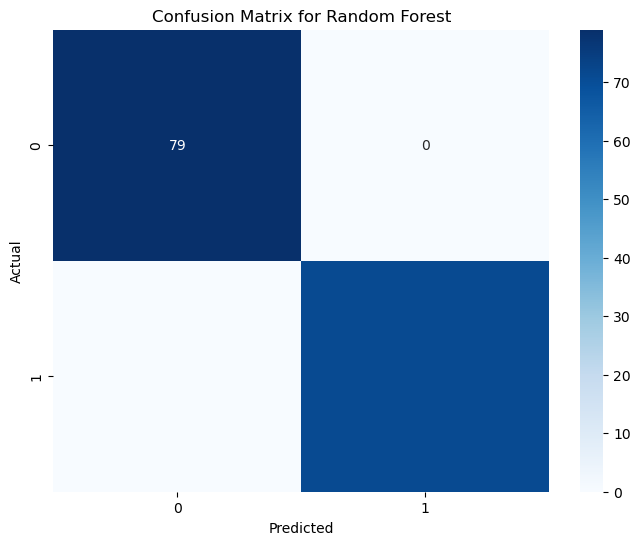

--- Gradient Boosting ---
Accuracy: 0.9866666666666667
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99        79
           1       0.99      0.99      0.99        71

    accuracy                           0.99       150
   macro avg       0.99      0.99      0.99       150
weighted avg       0.99      0.99      0.99       150

Confusion Matrix:
[[78  1]
 [ 1 70]]


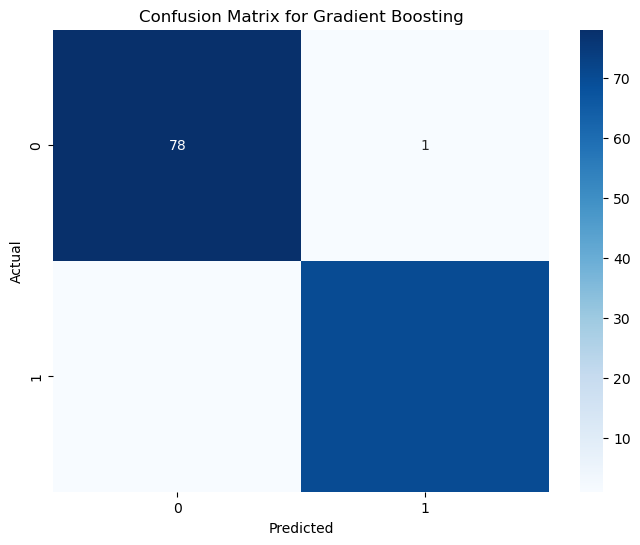

--- Support Vector Machine ---
Accuracy: 0.9933333333333333
Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99        79
           1       1.00      0.99      0.99        71

    accuracy                           0.99       150
   macro avg       0.99      0.99      0.99       150
weighted avg       0.99      0.99      0.99       150

Confusion Matrix:
[[79  0]
 [ 1 70]]


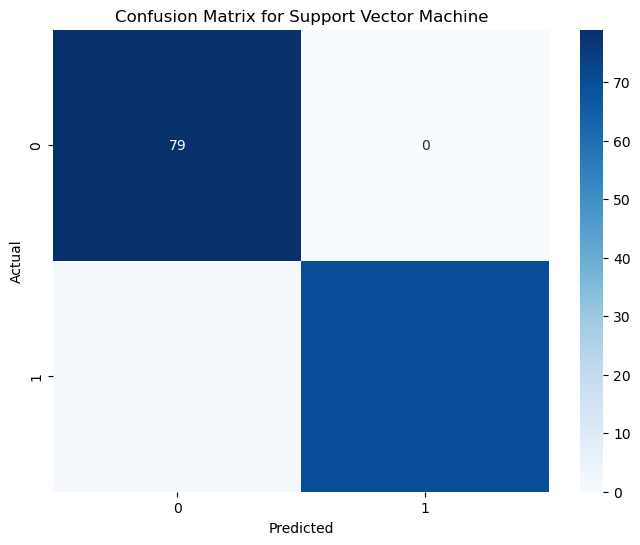

--- Voting Classifier ---
Accuracy: 1.0
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        79
           1       1.00      1.00      1.00        71

    accuracy                           1.00       150
   macro avg       1.00      1.00      1.00       150
weighted avg       1.00      1.00      1.00       150

Confusion Matrix:
[[79  0]
 [ 0 71]]


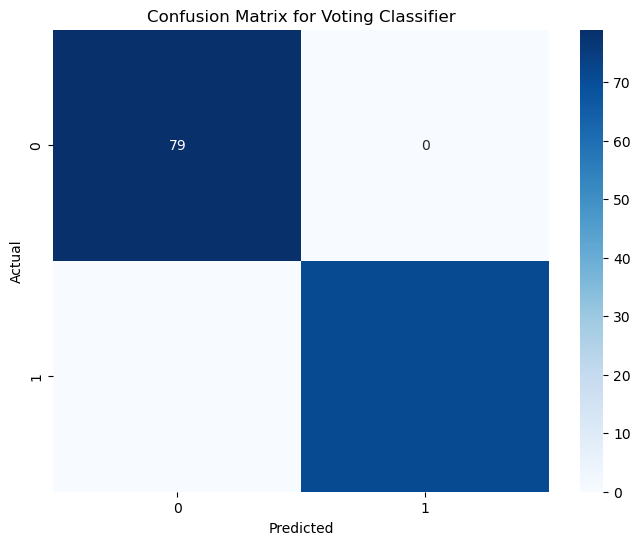

In [33]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.svm import SVC
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming flat_data and targets are already defined
# Split the dataset into training and testing sets
# x_train, x_test, y_train, y_test = train_test_split(flat_data, targets, test_size=0.5, random_state=42)

# Initialize individual classifiers
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
gb_classifier = GradientBoostingClassifier(n_estimators=100, random_state=42)
svm_classifier = SVC(kernel='linear', C=0.1, probability=True)

# Fit each classifier
rf_classifier.fit(x_train, y_train)
gb_classifier.fit(x_train, y_train)
svm_classifier.fit(x_train, y_train)

# Make predictions
y_pred_rf = rf_classifier.predict(x_test)
y_pred_gb = gb_classifier.predict(x_test)
y_pred_svm = svm_classifier.predict(x_test)

# Voting Classifier
voting_classifier = VotingClassifier(estimators=[
    ('rf', rf_classifier),
    ('gb', gb_classifier),
    ('svm', svm_classifier)
], voting='soft')

# Fit the voting classifier
voting_classifier.fit(x_train, y_train)
y_pred_voting = voting_classifier.predict(x_test)

# Function to evaluate and print metrics
def evaluate_model(y_true, y_pred, model_name):
    print(f"--- {model_name} ---")
    print(f"Accuracy: {accuracy_score(y_true, y_pred)}")
    print(f"Classification Report:\n{classification_report(y_true, y_pred)}")
    
    # Confusion Matrix
    conf_matrix = confusion_matrix(y_true, y_pred)
    print(f"Confusion Matrix:\n{conf_matrix}")

# Evaluate each model
evaluate_model(y_test, y_pred_rf, "Random Forest")
evaluate_model(y_test, y_pred_gb, "Gradient Boosting")
evaluate_model(y_test, y_pred_svm, "Support Vector Machine")
evaluate_model(y_test, y_pred_voting, "Voting Classifier")


In [37]:
def evaluate_model(y_true, y_pred, model_name):
    print(f"--- {model_name} ---")
    print(f"Accuracy: {accuracy_score(y_true, y_pred)}")
    print(f"Classification Report:\n{classification_report(y_true, y_pred)}")
    
    # Confusion Matrix
    conf_matrix = confusion_matrix(y_true, y_pred)
    print(f"Confusion Matrix:\n{conf_matrix}")

# Evaluate each model
evaluate_model(y_test, y_pred_rf, "Random Forest")
evaluate_model(y_test, y_pred_gb, "Gradient Boosting")
evaluate_model(y_test, y_pred_svm, "Support Vector Machine")
evaluate_model(y_test, y_pred_voting, "Voting Classifier")

--- Random Forest ---
Accuracy: 1.0
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        79
           1       1.00      1.00      1.00        71

    accuracy                           1.00       150
   macro avg       1.00      1.00      1.00       150
weighted avg       1.00      1.00      1.00       150

Confusion Matrix:
[[79  0]
 [ 0 71]]
--- Gradient Boosting ---
Accuracy: 0.9866666666666667
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99        79
           1       0.99      0.99      0.99        71

    accuracy                           0.99       150
   macro avg       0.99      0.99      0.99       150
weighted avg       0.99      0.99      0.99       150

Confusion Matrix:
[[78  1]
 [ 1 70]]
--- Support Vector Machine ---
Accuracy: 0.9933333333333333
Classification Report:
              precision    recall  f1-score   suppor

In [59]:
import os
from skimage.io import imread
from skimage.transform import resize

def predict_image(image_path):
    img = imread(image_path)
    img_resized = resize(img, (100, 100, 3)).flatten()
    prediction = svc.predict([img_resized])
    return categories[prediction[0]]

def predict_images_in_folder(folder_path):
    predictions = []
    for filename in os.listdir(folder_path):
        if filename.endswith(".Png") or filename.endswith(".jpg"):  # Add other image formats if needed
            image_path = os.path.join(folder_path, filename)
            prediction = predict_image(image_path)
            predictions.append((filename, prediction))
    return predictions

folder_path = r"C:\Users\scallred\OneDrive - Keysight Technologies\Desktop\MIDS_SVC_MODEL\TEST"
predictions = predict_images_in_folder(folder_path)

for filename, prediction in predictions:
    print(f"Image: {filename}, Prediction: {prediction}")


Image: 1081PROTO-MIDSB-2407291_A4187055SW1100B0C2_SLOT06_Zz_MIDS_BACKSIDE_BF_SELECT_20240729-1408_WHITE_RAW.Png, Prediction: PASS
Image: 1081PROTO-MIDSB-2407291_A4187077SW1100B0G6_SLOT07_Zz_MIDS_BACKSIDE_BF_SELECT_20240729-1409_WHITE_RAW.Png, Prediction: PASS
Image: 1081PROTO-MIDSB-2407291_A4187079SW1100B0H2_SLOT04_Zz_MIDS_BACKSIDE_BF_SELECT_20240729-1407_WHITE_RAW.Png, Prediction: PASS
Image: 1081PROTO-MIDSB-2407291_A4187080SW1100B0H0_SLOT05_Zz_MIDS_BACKSIDE_BF_SELECT_20240729-1408_WHITE_RAW.Png, Prediction: PASS
Image: 1081PROTO-MIDSB-2407291_A4187089SW1100B0B7_SLOT08_Zz_MIDS_BACKSIDE_BF_SELECT_20240729-1410_WHITE_RAW.Png, Prediction: PASS
Image: 1081PROTO-MIDSB-2407291_A4187101SW1100B0H2_SLOT02_Zz_MIDS_BACKSIDE_BF_SELECT_20240729-1406_WHITE_RAW.Png, Prediction: PASS
Image: 1081PROTO-MIDSB-2407291_NO-WID_SLOT03_Zz_MIDS_BACKSIDE_BF_SELECT_20240729-1406_WHITE_RAW.Png, Prediction: PASS
Image: 7451BSOSN-MIDS-24042311_50000518PR0530B0G5_SLOT25_Zz_MIDS_BACKSIDE_BFDF_SELECT_20240423-1203_WH

In [88]:
import os
from skimage.io import imread
from skimage.transform import resize
import tkinter as tk
from tkinter import messagebox
from concurrent.futures import ThreadPoolExecutor

def predict_image(image_path):
    img = imread(image_path)
    img_resized = resize(img, (1000, 1000, 3)).flatten()
    prediction = svc.predict([img_resized])
    return categories[prediction[0]]

def process_image(image_path):
    prediction = predict_image(image_path)
    return (image_path, prediction)

def predict_images_in_folder(folder_path):
    predictions = []
    valid_extension = "WHITE_RAW.Png"
    count = 0

    with ThreadPoolExecutor() as executor:
        futures = []
        for root, _, files in os.walk(folder_path):
            for filename in files:
                if filename.endswith(valid_extension) and "FRONTSIDE" not in filename:
                    image_path = os.path.join(root, filename)
                    futures.append(executor.submit(process_image, image_path))
                    count += 1
# #Use this code to step through 100 at a time.
#                     if count % 100 == 0:
#                         results = [future.result() for future in futures[-100:]]
#                         show_popup(results)
#                         if not ask_continue():
#                             return predictions + results

        for future in futures:
            predictions.append(future.result())

    return predictions

def show_popup(results):
    root = tk.Tk()
    root.withdraw()
    result_text = "\n".join([f"Image: {os.path.basename(filename)}, Prediction: {prediction}" for filename, prediction in results])
    messagebox.showinfo("Predictions", result_text)
    root.destroy()

def ask_continue():
    root = tk.Tk()
    root.withdraw()
    result = messagebox.askyesno("Continue?", "Do you want to continue processing more files?")
    root.destroy()
    return result

folder_path = r"B:\ManufacturingData\SORTER-1\20240816_ImageDump"
predictions = predict_images_in_folder(folder_path)

fail_predictions = [(os.path.basename(filename), prediction) for filename, prediction in predictions if prediction == "FAIL"]
df = pd.DataFrame(fail_predictions, columns=["Filename", "Prediction"])

for filename, prediction in predictions:
    print(f"Image: {os.path.basename(filename)}, Prediction: {prediction}")


Image: 0004SOSNOWCH-MIDS-24041_00001052PR0530B0F7_SLOT02_Zz_MIDS_BACKSIDE_BFDF_SELECT_20240417-1025_WHITE_RAW.Png, Prediction: PASS
Image: 0004SOSNOWCH-MIDS-24041_00001072PR0530B0C4_SLOT06_Zz_MIDS_BACKSIDE_BFDF_SELECT_20240417-1028_WHITE_RAW.Png, Prediction: PASS
Image: 0004SOSNOWCH-MIDS-24041_00001073PR0530B0C6_SLOT07_Zz_MIDS_BACKSIDE_BFDF_SELECT_20240417-1028_WHITE_RAW.Png, Prediction: PASS
Image: 0004SOSNOWCH-MIDS-24041_00001074PR0530B0D0_SLOT08_Zz_MIDS_BACKSIDE_BFDF_SELECT_20240417-1029_WHITE_RAW.Png, Prediction: PASS
Image: 0004SOSNOWCH-MIDS-24041_00001075PR0530B0D2_SLOT09_Zz_MIDS_BACKSIDE_BFDF_SELECT_20240417-1030_WHITE_RAW.Png, Prediction: PASS
Image: 0004SOSNOWCH-MIDS-24041_00001081PR0530B0E2_SLOT05_Zz_MIDS_BACKSIDE_BFDF_SELECT_20240417-1027_WHITE_RAW.Png, Prediction: PASS
Image: 0004SOSNOWCH-MIDS-24041_00001082PR0530B0E4_SLOT04_Zz_MIDS_BACKSIDE_BFDF_SELECT_20240417-1026_WHITE_RAW.Png, Prediction: PASS
Image: 0004SOSNOWCH-MIDS-24041_00001099PR0530B0A7_SLOT03_Zz_MIDS_BACKSIDE_BF

In [94]:
print(df)

                                             Filename Prediction
0   2715PROTO-MIDSB-2407290_A4187031SW1100B0E5_SLO...       FAIL
1   2715PROTO-MIDSB-2407290_A4187032SW1100B0E7_SLO...       FAIL
2   2715PROTO-MIDSB-2407290_A4187033SW1100B0F1_SLO...       FAIL
3   2715PROTO-MIDSB-2407290_A4187034SW1100B0F3_SLO...       FAIL
4   2715PROTO-MIDSB-2407290_A4187035SW1100B0F5_SLO...       FAIL
..                                                ...        ...
85  QUAL0003-2_NO-WID_SLOT21_2_MIDS_200mm_CaptureW...       FAIL
86  QUAL0003-2_NO-WID_SLOT22_2_MIDS_200mm_CaptureW...       FAIL
87  QUAL0003-2_NO-WID_SLOT23_2_MIDS_200mm_CaptureW...       FAIL
88  QUAL0003-2_NO-WID_SLOT24_2_MIDS_200mm_CaptureW...       FAIL
89  QUAL0003-2_NO-WID_SLOT25_2_MIDS_200mm_CaptureW...       FAIL

[90 rows x 2 columns]


In [96]:
# Save the DataFrame to a CSV file named "df.csv"
df.to_csv("FAIL_outputs.csv", index=False)

# Print a success message
print("DataFrame was successfully saved to df.csv")

DataFrame was successfully saved to df.csv


In [ ]:
fig, axes = plt.subplots(1, 5, figsize=(20, 5))
for i, ax in enumerate(axes):
    ax.imshow(flat_data[i].reshape(1000, 1000, 3))
    ax.set_title(f"Category: {categories[targets[i]]}")
    ax.axis('off')
plt.show()

In [50]:
# import os
# from skimage.io import imread
# from skimage.transform import resize
# import tkinter as tk
# from tkinter import messagebox
# from concurrent.futures import ThreadPoolExecutor
# import smtplib
# from email.mime.multipart import MIMEMultipart
# from email.mime.text import MIMEText

# def send_email(subject, body, to_email):
#     from_email = "your_email@domain.com"
#     password = "your_password"

#     msg = MIMEMultipart()
#     msg['From'] = from_email
#     msg['To'] = to_email
#     msg['Subject'] = subject

#     msg.attach(MIMEText(body, 'plain'))

#     server = smtplib.SMTP('smtp.office365.com', 587)
#     server.starttls()
#     server.login(from_email, password)
#     text = msg.as_string()
#     server.sendmail(from_email, to_email, text)
#     server.quit()

# def predict_image(image_path):
#     img = imread(image_path)
#     img_resized = resize(img, (1000, 1000, 3)).flatten()
#     prediction = svc.predict([img_resized])
#     return categories[prediction[0]]

# def process_image(image_path):
#     prediction = predict_image(image_path)
#     return (image_path, prediction)

# def predict_images_in_folder(folder_path):
#     predictions = []
#     valid_extension = "WHITE_RAW.Png"
#     count = 0

#     with ThreadPoolExecutor() as executor:
#         futures = []
#         for root, _, files in os.walk(folder_path):
#             for filename in files:
#                 if filename.endswith(valid_extension) and "FRONTSIDE" not in filename:
#                     image_path = os.path.join(root, filename)
#                     futures.append(executor.submit(process_image, image_path))
#                     count += 1
# #Use this code to step through 20 at a time.
#                     # if count % 20 == 0:
#                     #     results = [future.result() for future in futures[-20:]]
#                     #     show_popup(results)
#                     #     if not ask_continue():
#                     #         return predictions + results

#         for future in futures:
#             predictions.append(future.result())

#     return predictions

# def show_popup(results):
#     root = tk.Tk()
#     root.withdraw()
#     result_text = "\n".join([f"Image: {os.path.basename(filename)}, Prediction: {prediction}" for filename, prediction in results])
#     messagebox.showinfo("Predictions", result_text)
#     root.destroy()

# def ask_continue():
#     root = tk.Tk()
#     root.withdraw()
#     result = messagebox.askyesno("Continue?", "Do you want to continue processing more files?")
#     root.destroy()
#     return result

# folder_path = r"B:\ManufacturingData\SORTER-1\20240816_ImageDump"
# predictions = predict_images_in_folder(folder_path)

# failures = [f for f in predictions if f[1] == 'FAIL']

# if failures:
#     subject = "Image Processing Failures"
#     body = "\n".join([f"Image: {os.path.basename(filename)}, Prediction: {prediction}" for filename, prediction in failures])
#     send_email(subject, body, "scott.allred@keysight.com")

# for filename, prediction in predictions:
#     print(f"Image: {os.path.basename(filename)}, Prediction: {prediction}")
# AI-generated code. Review and use carefully. More info on FAQ.
# Replace "your_email@domain.com" and "your_password" with your actual Outlook email and password. This script will send an email to scott.allred@keysight.com if any image prediction results in “FAIL.”